In [3]:
!pip3 install scikit-surprise




[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [4]:
from surprise import NMF
from surprise.model_selection import cross_validate, KFold

from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import numpy as np
import torch
from torch.optim import SGD
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import pandas as pd


# Run Nonnegative Matrix Factorization

In [5]:

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

from surprise import Dataset, Reader, NMF
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, NMF
import numpy as np
import pandas as pd

# Load the movielens-100k dataset
data = Dataset.load_builtin('ml-100k')

def get_random_users(n_users=943):
    """
    Get random sample of user indices
    
    Args:
        n_users: Number of users to randomly sample
    
    Returns:
        Array of randomly sampled user indices
    """
    # Get total number of users in dataset
    raw_ratings = data.raw_ratings
    df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
    total_users = df['user_id'].nunique()
    
    # Random sample of users
    sampled_users = np.random.choice(np.arange(total_users), size=n_users, replace=False)
    
    return sampled_users

def get_sampled_embeddings(n_factors=10, user_indices=None):
    """
    Compute NMF on full dataset and filter for specific users
    
    Args:
        n_factors: Number of latent factors for NMF
        user_indices: Indices of users to keep. If None, keeps all users
    
    Returns:
        User embeddings matrix filtered for specified users
    """
    # Convert the dataset to a pandas DataFrame
    raw_ratings = data.raw_ratings
    df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
    
    # Compute NMF on full dataset
    reader = Reader(rating_scale=(1, 5))
    full_data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)
    
    # Train NMF on full dataset
    algo = NMF(n_factors=n_factors)
    trainset = full_data.build_full_trainset()
    algo.fit(trainset)
    
    # Get user embeddings
    user_embeddings = algo.pu
    
    # Filter embeddings if user_indices provided
    if user_indices is not None:
        user_embeddings = user_embeddings[user_indices]
    
    return user_embeddings

# Compute threshold $\beta_u$

In [6]:

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_beta_threshold_upper(user_embeddings_np, p=2):

    user_embeddings_np = user_embeddings_np
    N = user_embeddings_np.shape[0] # number of users 
    q = 1/(1-1/p) # dual norm 

    normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np, ord=q, axis=1, keepdims=True)
    sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
    beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows, ord=q)))

    return beta_ub

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for q = 2 
def get_beta_threshold_cost_weights(user_embeddings_np, cost_weights, p=2):

    N = user_embeddings_np.shape[0]
    normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np * np.power(cost_weights, -1), ord=2, axis=1, keepdims=True)
    sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
    beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows * np.power(cost_weights, -1), ord=2)))

    return beta_ub





## Compute threshold $\beta_e$ 

In [7]:

# Figure out if there is a point in convex hull of ball with objective > 0
def condition(ball):
    # Number of points and dimensions
    num_points = ball.shape[0]
    num_dims = ball.shape[1]
    
    param = 1.5e-6
    
    # tune tolerance to the number of users
    if num_dims == 30:
        param = 1.5e-6
    if num_dims == 20:
        param = 0.85e-6
    if num_dims == 40:
        param = 1.9e-6

    weights = cp.Variable(num_points)

    weighted_sums = cp.sum(cp.log(cp.matmul(ball.T, weights)))

    constraints = [
        weights >= 0,
        cp.sum(weights) == 1,
        weighted_sums >= param
    ]

    prob = cp.Problem(cp.Maximize(1), constraints)

    prob.solve(abstol=1e-7)
        
    if prob.status == 'optimal':
        print("The problem is feasible.")
        in_convex_hull = True
    else:
        print("The problem is infeasible.")
        in_convex_hull = False 
    
    return in_convex_hull


def binary_search_for_beta(lower_bound, upper_bound, max_point, user_embeddings_np, p, tolerance=0.1):
    
    T = 50
    num_samples = 75
    D = user_embeddings_np.shape[1] # dimension
    N = user_embeddings_np.shape[0] # number of users 
    projected_max_point = max_point @ user_embeddings_np.T 
    
    while upper_bound - lower_bound > tolerance:
        mid = (upper_bound + lower_bound) / 2
        print('\n')
        print(f'beta = {mid}')
        print(f'mid={mid}, lower bound = {lower_bound}, upper bound = {upper_bound}')

        condition_holds = False 
        for t in range(T):
            # Build ball to test in 
            random_points = np.random.multivariate_normal(np.zeros(D), np.eye(D), num_samples)

            random_points = np.abs(random_points) 

            # Scale by the norm
            norms = np.linalg.norm(random_points, axis=1, keepdims=True, ord=p)
        
            random_points = random_points / norms
        
            ball = np.vstack([random_points, max_point])
            
            ball = ball @ user_embeddings_np.T 
  
            inside_ball = ball / projected_max_point # divide out the target 

            # Compute powers 
            powered = np.power(inside_ball, mid)


            condition_holds = condition(powered)

            if condition_holds:
                break 
                
        if condition_holds:
            upper_bound = mid
        else:
            lower_bound = mid 
            
    return (upper_bound + lower_bound) / 2

# Get the single-genre equilibrium direction
def get_maximum(user_embeddings_np, p=2):
    
    N = user_embeddings_np.shape[0] # number of users 
    D = user_embeddings_np.shape[1] # dimension
    point = cp.Variable(D)

    constraints = [
        cp.pnorm(point, p) <= 1,
    ]

    prob = cp.Problem(cp.Maximize(cp.sum(cp.log(cp.matmul(user_embeddings_np, point)))), constraints)

    prob.solve()
    
    # Check if the problem is feasible
    return np.array(point.value)
    

def get_beta_threshold(user_embeddings_np, p=2):
    
    N = user_embeddings_np.shape[0] # number of users 
    D = user_embeddings_np.shape[1] # dimension

    print(N, D)

    max_point = get_maximum(user_embeddings_np, p=p)
    
    print(f'upper bound: {get_beta_threshold_upper(user_embeddings_np, p)}')
    beta_ub = get_beta_threshold_upper(user_embeddings_np, p)
    beta_lb = 1

    eps=0.05
    
    print("start binary search")
    
    beta_max = binary_search_for_beta(beta_lb, beta_ub, max_point, user_embeddings_np, p, tolerance=eps)

    return beta_max


# Compute single-genre equilibrium $p^*$ 

In [8]:

# Compute the single-genre equilibrium p^* for cost functions c_{q, \alpha, \beta} for q = 2 
def get_first_objective(U, dim, p=2, learning_rate=1.0, cost_weights=None):
    x = cp.Variable(dim)
    objective = cp.Maximize(cp.sum(cp.log(U @ x)))
    constraints = [cp.norm(cp.multiply(x, cost_weights), p) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(x.value)
    return x.value

def get_first_objective_no_cost(U, dim, p=2, learning_rate=1.0):
    x = cp.Variable(dim)
    objective = cp.Maximize(cp.sum(cp.log(U @ x)))
    constraints = [cp.pnorm(x, p) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(x.value)
    return x.value
    
# Project onto q-norm ball 
def project_onto_norm_ball(x, q, cost_weights):
    dim = len(x)
    y = cp.Variable(dim)
    objective = cp.Minimize(cp.norm2(x-y))
    constraints = [cp.norm(cp.multiply(y, cost_weights), q) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return y.value

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_first_objective_old(U, D, p=2, learning_rate=1.0, cost_weights=None):
    if cost_weights==None:
        cost_weights = torch.ones(D)

    x = torch.clamp(torch.randn(D), min=1.0)
    x.requires_grad = True
    optimizer = SGD([x], lr=learning_rate)
    num_iterations = 100

    for _ in tqdm(range(num_iterations)):
        optimizer.zero_grad()

        loss = -1 * torch.sum(torch.log(torch.matmul(U, x)))

        loss.backward()  # computes the gradient

        optimizer.step()

        with torch.no_grad():
            x.clamp_(min=0)
            x_numpy = x.detach().numpy()
            projected_x = project_onto_norm_ball(x_numpy, p, cost_weights)
            x.copy_(torch.from_numpy(projected_x))
  
    print(x)
    print("Objective:", -1 * loss.item())

    return x.detach().numpy(), -1 * loss.item()



# Generate data for plots 

In [18]:

# Compute \beta_u data across different dimensions and values of q

def get_betas_upper_bound_all(p_values, dim_values):
    betas = []
    for j in range(len(dim_values)):
        betas_p = []
        dim = dim_values[j]
        user_embeddings_np = get_sampled_embeddings(dim, user_indices=None)
      
        for i in range(len(p_values)):
            q = p_values[i]
            beta_ub = get_beta_threshold_upper(user_embeddings_np, p=q)
            betas_p.append(beta_ub)

            print(f'beta value: {beta_ub} at D = {dim} at p = {q}')
            print('\n\n')

        betas.append(betas_p)
    return betas



In [10]:



# Compute \beta_e data across different dimensions and values of N

def get_betas_all(N_values, dim_values):
    betas = []
    for i in range(len(N_values)):
        N = N_values[i]
        random_users = get_random_users(n_users=N)
        betas_p = []
        for j in range(len(dim_values)):
            dim = dim_values[j]
            user_embeddings_np = get_sampled_embeddings(dim, user_indices=random_users)
            beta = get_beta_threshold(user_embeddings_np, p=2)
            betas_p.append(beta)

            print(f'beta value: {beta} at D = {dim} at N = {N}')
            print('\n\n')

        betas.append(betas_p)
    return betas

In [11]:
# Compute single-genre equilibria data 

def get_data_costs_weighted(dim, costs_weights_all):
    user_embeddings = get_sampled_embeddings(dim, user_indices=None)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = 4
    p_vals = []
    for i in range(S):
        cost_weights = costs_weights_all[i]
        p = get_first_objective(U, dim, p=2, cost_weights=cost_weights)
        p = p / np.linalg.norm(p)
        print(f'alpha = {cost_weights}, p = {p / np.sum(p)}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



def get_data_costs_qvals(dim, q_vals):
    user_embeddings = get_sampled_embeddings(dim, user_indices=None)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = len(q_vals)
    p_vals = []
    for i in range(S):
        q = q_vals[i]
        p = get_first_objective_no_cost(U, dim, p=q)
        p = p / np.linalg.norm(p)
        print(f'q = {q}, p = {p}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



In [12]:

# Generate S weight vectors \alpha 
def generate_cost_weights(dim, S):
    cost_weights_all = []
    if dim == 3:
        for i in range(S):
            cost_weights = torch.rand(dim)
            cost_weights = cost_weights / torch.sum(cost_weights)
            cost_weights_all.append(cost_weights)
    if dim == 2:
        for i in range(S):
            shift = 1/(2 * S)
            cost_weights = torch.zeros(dim)
            cost_weights[0] = shift + (i / (S+1))
            cost_weights[1] = 1 - cost_weights[0]
            cost_weights_all.append(cost_weights)
    return cost_weights_all

In [13]:

cost_weights_all_2d = generate_cost_weights(2, 4)
p_vals_weighted2, user_embeddings_weighted2, mean_embedding_weighted2  = get_data_costs_weighted(2, cost_weights_all_2d)

# Save data to a file
np.savetxt('./Data/p_vals_weighted2.txt', p_vals_weighted2)
np.savetxt('./Data/user_embeddings_weighted2.txt', user_embeddings_weighted2)
np.savetxt('./Data/mean_embedding_weighted2.txt', mean_embedding_weighted2)
np.savetxt('./Data/cost_weights_all_2d.txt', cost_weights_all_2d)



[7.91760375 0.16360419]
alpha = tensor([0.1250, 0.8750]), p = [0.97975498 0.02024502]
[2.78302401 0.63186691]
alpha = tensor([0.3250, 0.6750]), p = [0.81496718 0.18503282]
[1.32696561 1.5103251 ]
alpha = tensor([0.5250, 0.4750]), p = [0.46768757 0.53231243]
[0.54179202 3.3440885 ]
alpha = tensor([0.7250, 0.2750]), p = [0.1394258 0.8605742]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [14]:

# Generate data
cost_weights_all_3d = generate_cost_weights(3, 4)
p_vals_weighted3, user_embeddings_weighted3, mean_embedding_weighted3 = get_data_costs_weighted(3, cost_weights_all_3d)

# Save data to file
np.savetxt('./Data/cost_weights_all_3d.txt', cost_weights_all_3d)
np.savetxt('./Data/p_vals_weighted3.txt', p_vals_weighted3)
np.savetxt('./Data/user_embeddings_weighted3.txt', user_embeddings_weighted3)
np.savetxt('./Data/mean_embedding_weighted3.txt', mean_embedding_weighted3)

[1.08340567 5.07761105 0.7691305 ]
alpha = tensor([0.3820, 0.1657, 0.4523]), p = [0.15633227 0.73268444 0.11098328]
[5.32194084 0.2015903  4.4181257 ]
alpha = tensor([0.1374, 0.7117, 0.1509]), p = [0.53531729 0.02027733 0.44440537]
[1.0842051  1.59621794 2.85989163]
alpha = tensor([0.4164, 0.3330, 0.2506]), p = [0.19569378 0.28810962 0.51619661]
[2.30067035 0.97161416 2.21010326]
alpha = tensor([0.2825, 0.4304, 0.2871]), p = [0.4196475  0.17722463 0.40312786]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [15]:

q_vals = [1.1, 1.5, 2, 3, 4]

# Generate data
p_vals_qvals2, user_embeddings_qvals2, mean_embedding_qvals2 = get_data_costs_qvals(2, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals2.txt', p_vals_qvals2)
np.savetxt('./Data/user_embeddings_qvals2.txt', user_embeddings_qvals2)
np.savetxt('./Data/mean_embedding_qvals2.txt', mean_embedding_qvals2)
np.savetxt('./Data/q_vals.txt', q_vals)

[0.58714589 0.47732789]
q = 1.1, p = [0.77593814 0.63080901]
[0.64602035 0.61369331]
q = 1.5, p = [0.72501401 0.68873412]
[0.71640091 0.69768886]
q = 2, p = [0.7164009  0.69768886]
[0.79899909 0.78833027]
q = 3, p = [0.71184334 0.70233828]
[0.84465703 0.83708468]
q = 4, p = [0.71028346 0.70391577]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [18]:
q_vals = [1.1, 1.5, 2, 3, 4]
# Generate data
p_vals_qvals3, user_embeddings_qvals3, mean_embedding_qvals3 = get_data_costs_qvals(3, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals3.txt', p_vals_qvals3)
np.savetxt('./Data/user_embeddings_qvals3.txt', user_embeddings_qvals3)
np.savetxt('./Data/mean_embedding_qvals3.txt', mean_embedding_qvals3)
np.savetxt('./Data/q_vals.txt', q_vals)

[0.3831292  0.36563867 0.35621314]
q = 1.1, p = [0.60027755 0.57287381 0.55810613]
[0.4856661  0.47988199 0.47667994]
q = 1.5, p = [0.58324563 0.57629939 0.57245398]
[0.58040535 0.57681476 0.57481681]
q = 2, p = [0.58040535 0.57681476 0.57481681]
[0.69522877 0.69303525 0.6918112 ]
q = 3, p = [0.57890649 0.57707998 0.57606073]
[0.76120803 0.75959641 0.75869624]
q = 4, p = [0.5783941  0.57716953 0.57648555]


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [31]:

N_vals = [30, 40]
dim_values = [4, 5, 6, 8]

# Generate data
betas = get_betas_all(N_vals, dim_values)

print(betas)

# Save data to files
np.savetxt('./Data/betas_actual.txt', betas)
np.savetxt('./Data/N_vals_actual.txt', N_vals)
np.savetxt('./Data/dim_values_actual.txt', dim_values)

30 4
upper bound: 83.6014881007373
start binary search


beta = 42.30074405036865
mid=42.30074405036865, lower bound = 1, upper bound = 83.6014881007373
The problem is feasible.


beta = 21.650372025184325
mid=21.650372025184325, lower bound = 1, upper bound = 42.30074405036865
The problem is feasible.


beta = 11.325186012592162
mid=11.325186012592162, lower bound = 1, upper bound = 21.650372025184325
The problem is infeasible.
The problem is feasible.


beta = 6.162593006296081
mid=6.162593006296081, lower bound = 1, upper bound = 11.325186012592162
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 3.5812965031480406
mid=3.5812965031480406, lower bound = 1, upper bound = 6.162593006296081
The problem is infeasible.
The problem is feasible.


beta = 2.2906482515740203
mid=2.2906482515740203, lower bound = 1, upper bound = 3.5812965031480406
The problem is infeasible.
The problem is infeasible.


/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 1.9261630890115509
mid=1.9261630890115509, lower bound = 1, upper bound = 2.8523261780231017
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The probl

The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
beta value: 2.8378548797572964 at D = 5 at N = 30



30 6
upper bound: 45.25976380165948
start binary search


beta = 23.12988190082974
mid=23.12988190082974, lower bound = 1, upper bound = 45.25976380165948
The problem is feasible.


beta = 12.06494095041487
mid=12.06494095041487, lower bound = 1, upper bound = 23.12988190082974
The problem is feasible.


beta = 6.532470475207435
mid=6.532470475207435, lower bound = 1, upper bound = 12.06494095041487
The problem is infeasible.
The problem is feasible.


beta = 3.7662352376037176
mid=3

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 1.8458149474232863
mid=1.8458149474232863, lower bound = 1, upper bound = 2.6916298948465727
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The probl

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is feasible.


beta = 2.012344450152047
mid=2.012344450152047, lower bound = 1, upper bound = 3.0246889003040933
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
T

/opt/homebrew/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The problem is infeasible.
The problem is feasible.


beta = 1.7108860407543356
mid=1.7108860407543356, lower bound = 1, upper bound = 2.421772081508671
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The problem is infeasible.
The proble

In [19]:


q_vals =  [1.5, 1.6, 1.8, 2.0]
dim_values = [5, 10, 20, 40]

betas = get_betas_upper_bound_all(q_vals, dim_values)

print(betas)

# Save data to files
np.savetxt('./Data/betas_small.txt', betas)
np.savetxt('./Data/q_vals_small.txt', q_vals)
np.savetxt('./Data/dim_values_small.txt', dim_values)
print(dim_values)
print(q_vals)

beta value: 70.31379744111602 at D = 5 at p = 1.5



beta value: 80.10679607505091 at D = 5 at p = 1.6



beta value: 99.54522405195358 at D = 5 at p = 1.8



beta value: 118.85363317488401 at D = 5 at p = 2.0



beta value: 41.881800935115805 at D = 10 at p = 1.5



beta value: 47.540796009359006 at D = 10 at p = 1.6



beta value: 58.77048242223281 at D = 10 at p = 1.8



beta value: 69.92183534105814 at D = 10 at p = 2.0



beta value: 29.744149027373076 at D = 20 at p = 1.5



beta value: 33.726987630593904 at D = 20 at p = 1.6



beta value: 41.624626474815564 at D = 20 at p = 1.8



beta value: 49.462535047113604 at D = 20 at p = 2.0



beta value: 24.912933887214276 at D = 40 at p = 1.5



beta value: 28.301495005294633 at D = 40 at p = 1.6



beta value: 35.008211539891214 at D = 40 at p = 1.8



beta value: 41.65533780024502 at D = 40 at p = 2.0



[[70.31379744111602, 80.10679607505091, 99.54522405195358, 118.85363317488401], [41.881800935115805, 47.540796009359006, 58.770482

In [20]:
q_vals = [1.1, 1.5, 2, 3, 4]

dim_values = [2, 3, 5, 10, 50]

# Generate data
betas = get_betas_upper_bound_all(q_vals, dim_values)

# Save data to files
np.savetxt('./Data/betas.txt', betas)
np.savetxt('./Data/q_vals.txt', q_vals)
np.savetxt('./Data/dim_values.txt', dim_values)

beta value: 92.3283938551576 at D = 2 at p = 1.1



beta value: 236.05517368887212 at D = 2 at p = 1.5



beta value: 416.71566036072363 at D = 2 at p = 2



beta value: 777.2411323574986 at D = 2 at p = 3



beta value: 1137.3918906267666 at D = 2 at p = 4



beta value: 49.25749404741997 at D = 3 at p = 1.1



beta value: 118.39754840858681 at D = 3 at p = 1.5



beta value: 203.99463279260786 at D = 3 at p = 2



beta value: 374.27899406666575 at D = 3 at p = 3



beta value: 544.1602709543298 at D = 3 at p = 4



beta value: 29.310845874780394 at D = 5 at p = 1.1



beta value: 68.31111429524417 at D = 5 at p = 1.5



beta value: 116.2483377430789 at D = 5 at p = 2



beta value: 211.30539059770135 at D = 5 at p = 3



beta value: 306.0700495084488 at D = 5 at p = 4



beta value: 18.00877403792516 at D = 10 at p = 1.1



beta value: 40.25026694367653 at D = 10 at p = 1.5



beta value: 67.27747622665991 at D = 10 at p = 2



beta value: 120.56749002699583 at D = 10 at p = 3



bet

# Plots

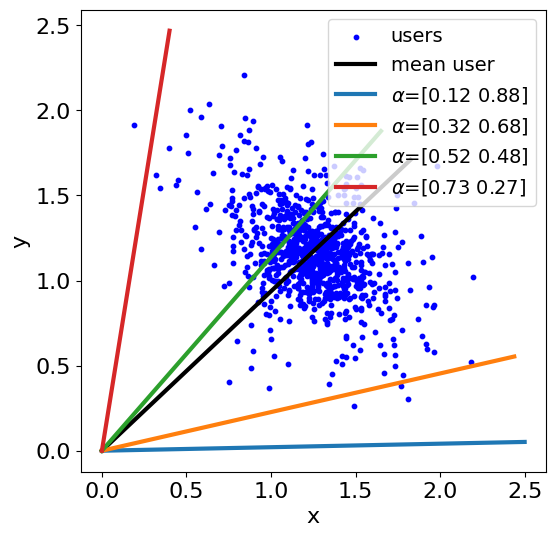

In [21]:

width = 6
height = 6

# Read data from files
p_vals_weighted2 = np.loadtxt('./Data/p_vals_weighted2.txt')
user_embeddings_weighted2 = np.loadtxt('./Data/user_embeddings_weighted2.txt')
mean_embedding_weighted2 = np.loadtxt('./Data/mean_embedding_weighted2.txt')

# Create a plot
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_weighted2[:, 0]
y_coordinates = user_embeddings_weighted2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)  # reduced marker size to 10
plt.plot(t * mean_embedding_weighted2[0], t * mean_embedding_weighted2[1], label='mean user', color='k', linewidth=3)

# Assuming cost_weights_all_2d is saved and needs to be loaded as well
cost_weights_all_2d = np.loadtxt('./Data/cost_weights_all_2d.txt')
for i in range(len(p_vals_weighted2)):
    p = p_vals_weighted2[i]
    cost_weights = cost_weights_all_2d[i]
    plt.plot(t * p[0], t * p[1], label=f'$\\alpha$={np.around(cost_weights, 2)}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-costs', bbox_inches='tight')




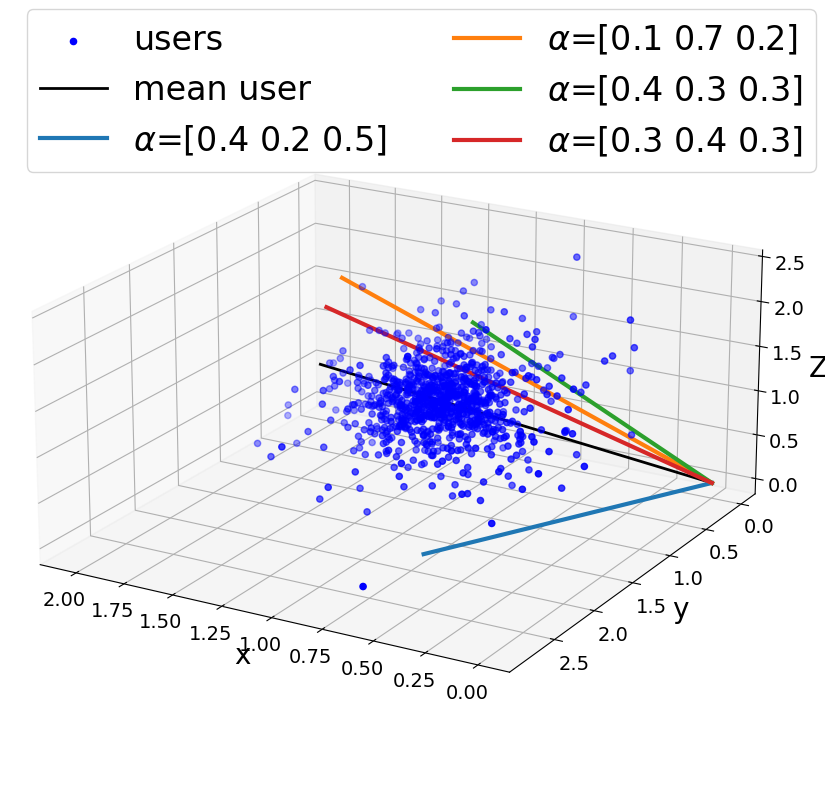

In [22]:


# Read data from files
cost_weights_all_3d = np.loadtxt('./Data/cost_weights_all_3d.txt')
p_vals_weighted3 = np.loadtxt('./Data/p_vals_weighted3.txt')
user_embeddings_weighted3 = np.loadtxt('./Data/user_embeddings_weighted3.txt')
mean_embedding_weighted3 = np.loadtxt('./Data/mean_embedding_weighted3.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

x_coordinates = user_embeddings_weighted3[:, 0]
y_coordinates = user_embeddings_weighted3[:, 1]
z_coordinates = user_embeddings_weighted3[:, 2]

t = np.linspace(0, 2.5, 100)

ax.scatter(x_coordinates, y_coordinates, z_coordinates, label='users', color='blue')
ax.plot(t * mean_embedding_weighted3[0], t * mean_embedding_weighted3[1], t * mean_embedding_weighted3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_weighted3)):
    p = p_vals_weighted3[i]
    cost_weights = cost_weights_all_3d[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'$\\alpha$={np.around(cost_weights, 1)}', linewidth=3)


ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-costs', bbox_inches='tight')


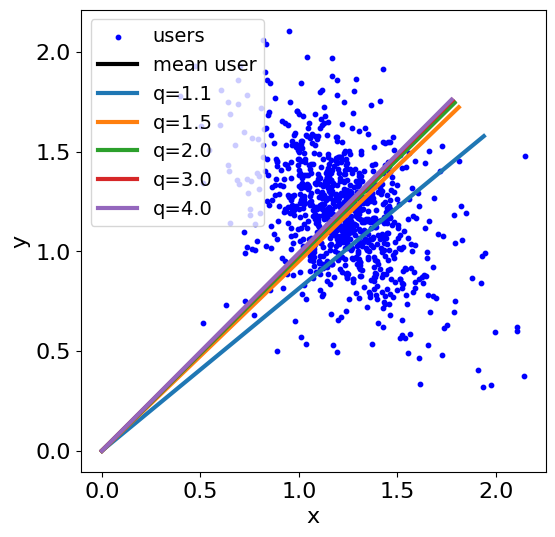

In [23]:
# Read data from files
p_vals_qvals2 = np.loadtxt('./Data/p_vals_qvals2.txt')
user_embeddings_qvals2 = np.loadtxt('./Data/user_embeddings_qvals2.txt')
mean_embedding_qvals2 = np.loadtxt('./Data/mean_embedding_qvals2.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 6
height = 6
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_qvals2[:, 0]
y_coordinates = user_embeddings_qvals2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)
plt.plot(t * mean_embedding_qvals2[0], t * mean_embedding_qvals2[1], label='mean user', color='k', linewidth=3)

for i in range(len(p_vals_qvals2)):
    p = p_vals_qvals2[i]
    q = q_vals[i]
    plt.plot(t * p[0], t * p[1], label=f'q={q}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-q', bbox_inches='tight')


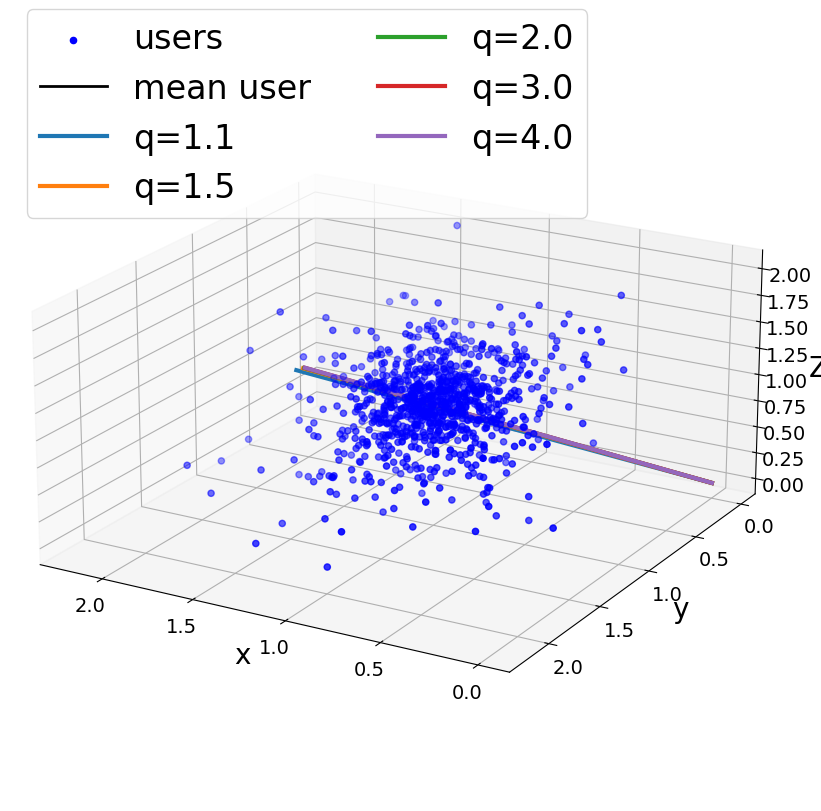

In [24]:

# Read data from files
p_vals_qvals3 = np.loadtxt('./Data/p_vals_qvals3.txt')
user_embeddings_qvals3 = np.loadtxt('./Data/user_embeddings_qvals3.txt')
mean_embedding_qvals3 = np.loadtxt('./Data/mean_embedding_qvals3.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

t = np.linspace(0, 2.5, 100)

ax.scatter(user_embeddings_qvals3[:, 0], user_embeddings_qvals3[:, 1], user_embeddings_qvals3[:, 2], label='users', color='blue')
ax.plot(t * mean_embedding_qvals3[0], t * mean_embedding_qvals3[1], t * mean_embedding_qvals3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_qvals3)):
    p = p_vals_qvals3[i]
    q = q_vals[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'q={q}', linewidth=3)

ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-q', bbox_inches='tight')


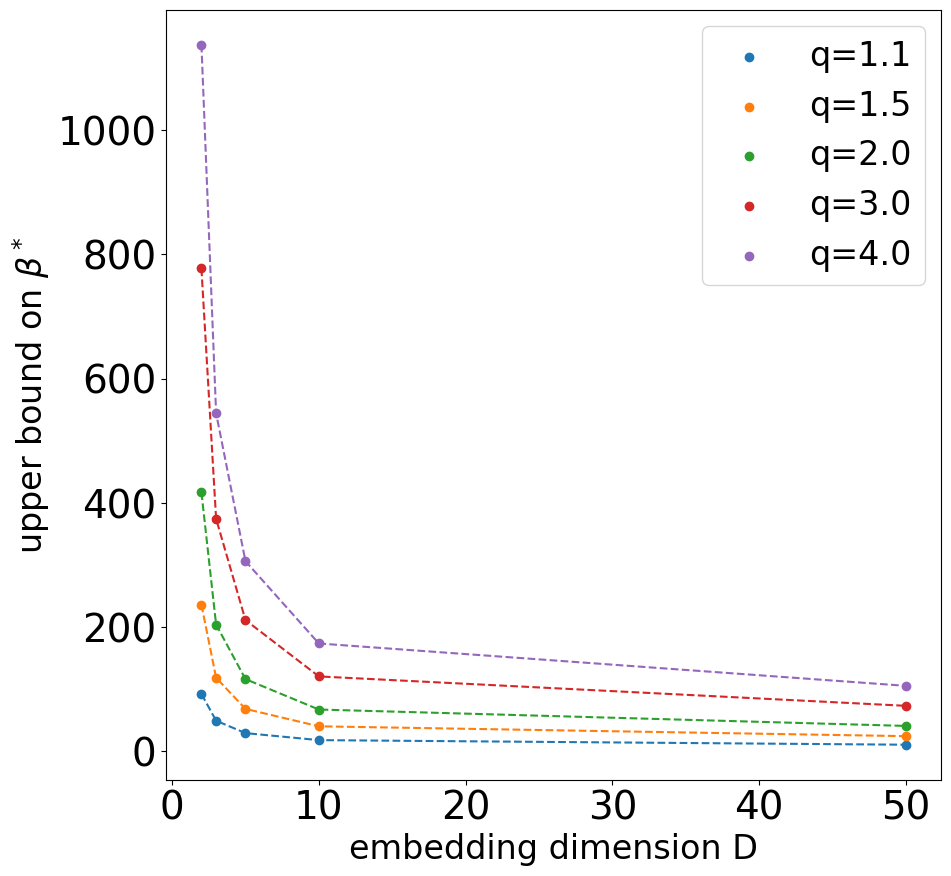

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')
dim_values = np.loadtxt('./Data/dim_values.txt')

width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(q_vals)):
    betas_val = betas[:, i]
    plt.scatter(dim_values, betas_val, label='q='+str(q_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('upper bound on $\\beta^*$', fontsize=24)
plt.savefig('./Plots/beta-q', bbox_inches='tight')


[1.5 1.6 1.8 2. ]
[[ 70.31379744  80.10679608  99.54522405 118.85363317]
 [ 41.88180094  47.54079601  58.77048242  69.92183534]
 [ 29.74414903  33.72698763  41.62462647  49.46253505]
 [ 24.91293389  28.30149501  35.00821154  41.6553378 ]]
[ 5. 10. 20. 40.]


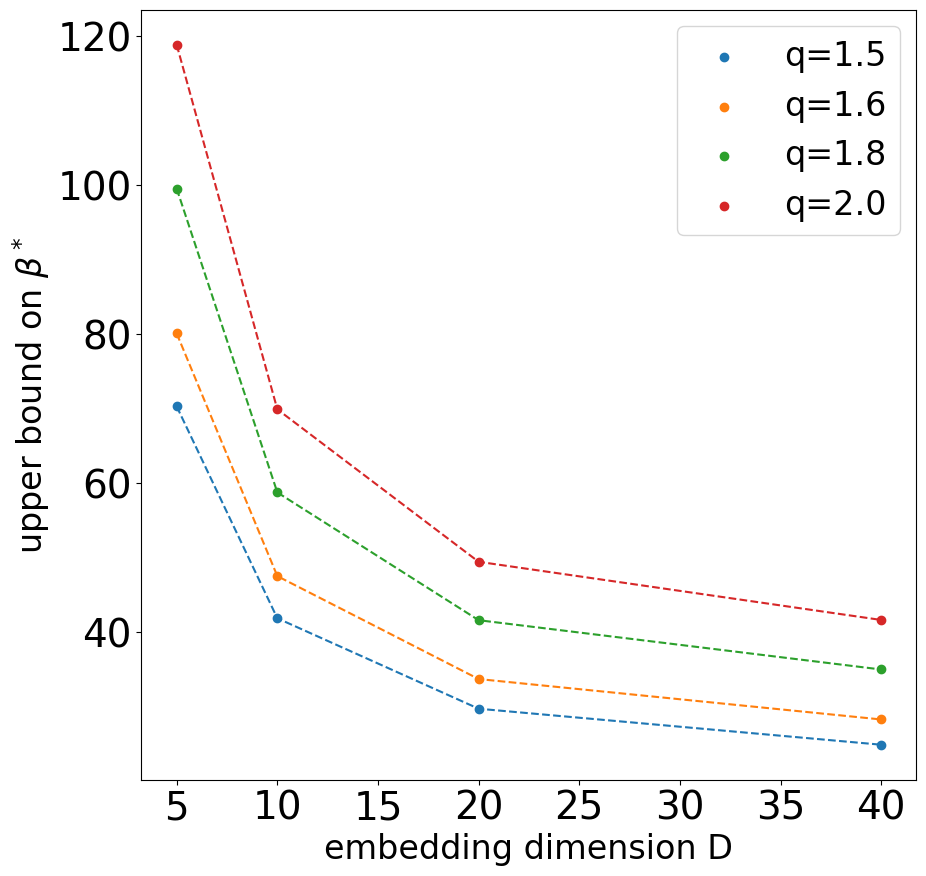

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas_small.txt')
q_vals = np.loadtxt('./Data/q_vals_small.txt')
dim_values = np.loadtxt('./Data/dim_values_small.txt')

print(q_vals)
print(betas)
print(dim_values)
width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(q_vals)):
    betas_val = betas[:, i]
    plt.scatter(dim_values, betas_val, label='q='+str(q_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('upper bound on $\\beta^*$', fontsize=24)
plt.savefig('./Plots/beta-q-small', bbox_inches='tight')


[3.11746979 2.83785488 2.79373066 2.58814638]
[2.59911888 2.31288421 2.186082   1.82196198]


Text(0, 0.5, 'estimate of $\\beta^*$')

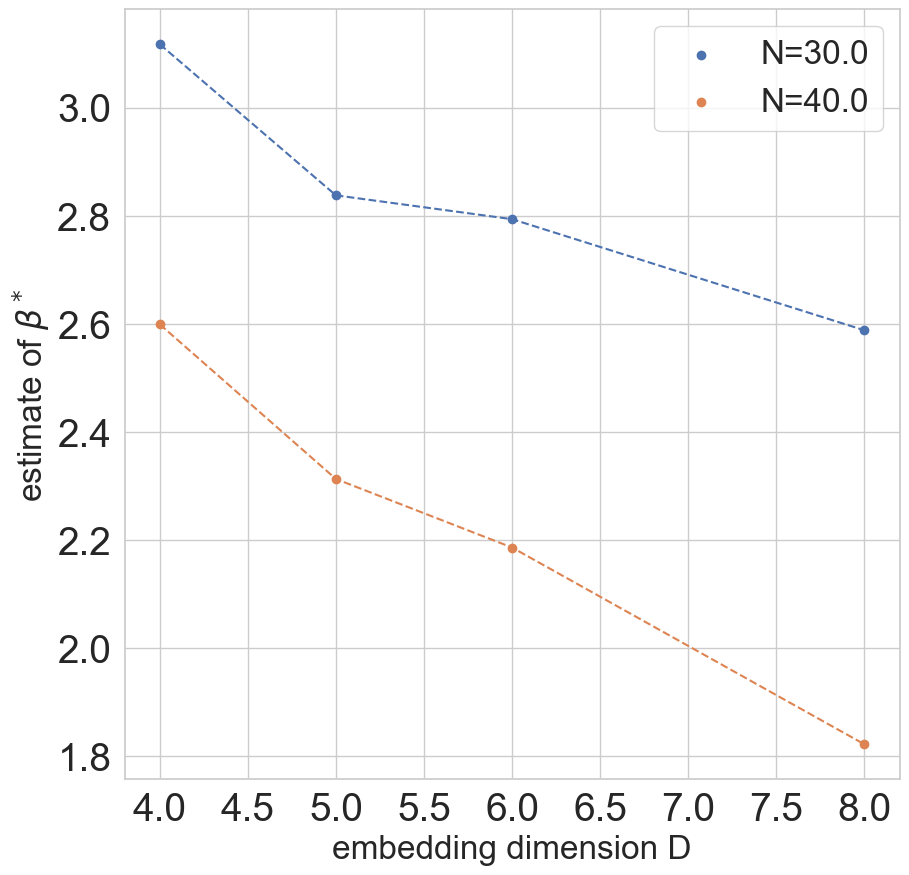

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas_actual.txt')
N_vals = np.loadtxt('./Data/N_vals_actual.txt')
dim_values = np.loadtxt('./Data/dim_values_actual.txt')

width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(N_vals)):
    betas_val = betas[i]
    print(betas_val)
    plt.scatter(dim_values, betas_val, label='N='+str(N_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('estimate of $\\beta^*$', fontsize=24)
# plt.savefig('./Plots/beta-q-actual', bbox_inches='tight')
